# 소프트맥스 회귀 Softmax Regression - 다항분류
## 다항분류(다중 클래스 분류)의 이해
### 1) 다항 분류
- 이진 분류: 두 개의 선택지 중 하나를 고르는 문제
    - -> 로지스틱 회귀
    - -> 종속변수: 0 또는 1
- `다항 분류`: 세 개 이상의 선택지 중 하나를 고르는 문제
    - -> 소프트맥스 회귀
    - -> 종속변수: 2개 이상


### 2) 소프트맥스 함수
- `다항 분류 활성화 함수`
- 뉴런의 출력값에 대하여 class 분류를 위하여 마지막 단계에서 `출력값에 대한 **정규화**를 해주는 함수`
- 결과물의 수치의 합은 언제나 1.0
- 그러므로, 소프트맥스 함수의 출력값은 `확률`로 해석할 수 있다
> 사진 속 인물이 지금 슬픈 표정인지, 웃는 표정인지, 화난 표정인지 확률적으로 수치화 한다고 했을 때,
>
> 슬픔(11%), 웃음(29%), 화남(60%)과 같이 확률적 분류를 할 때 용이

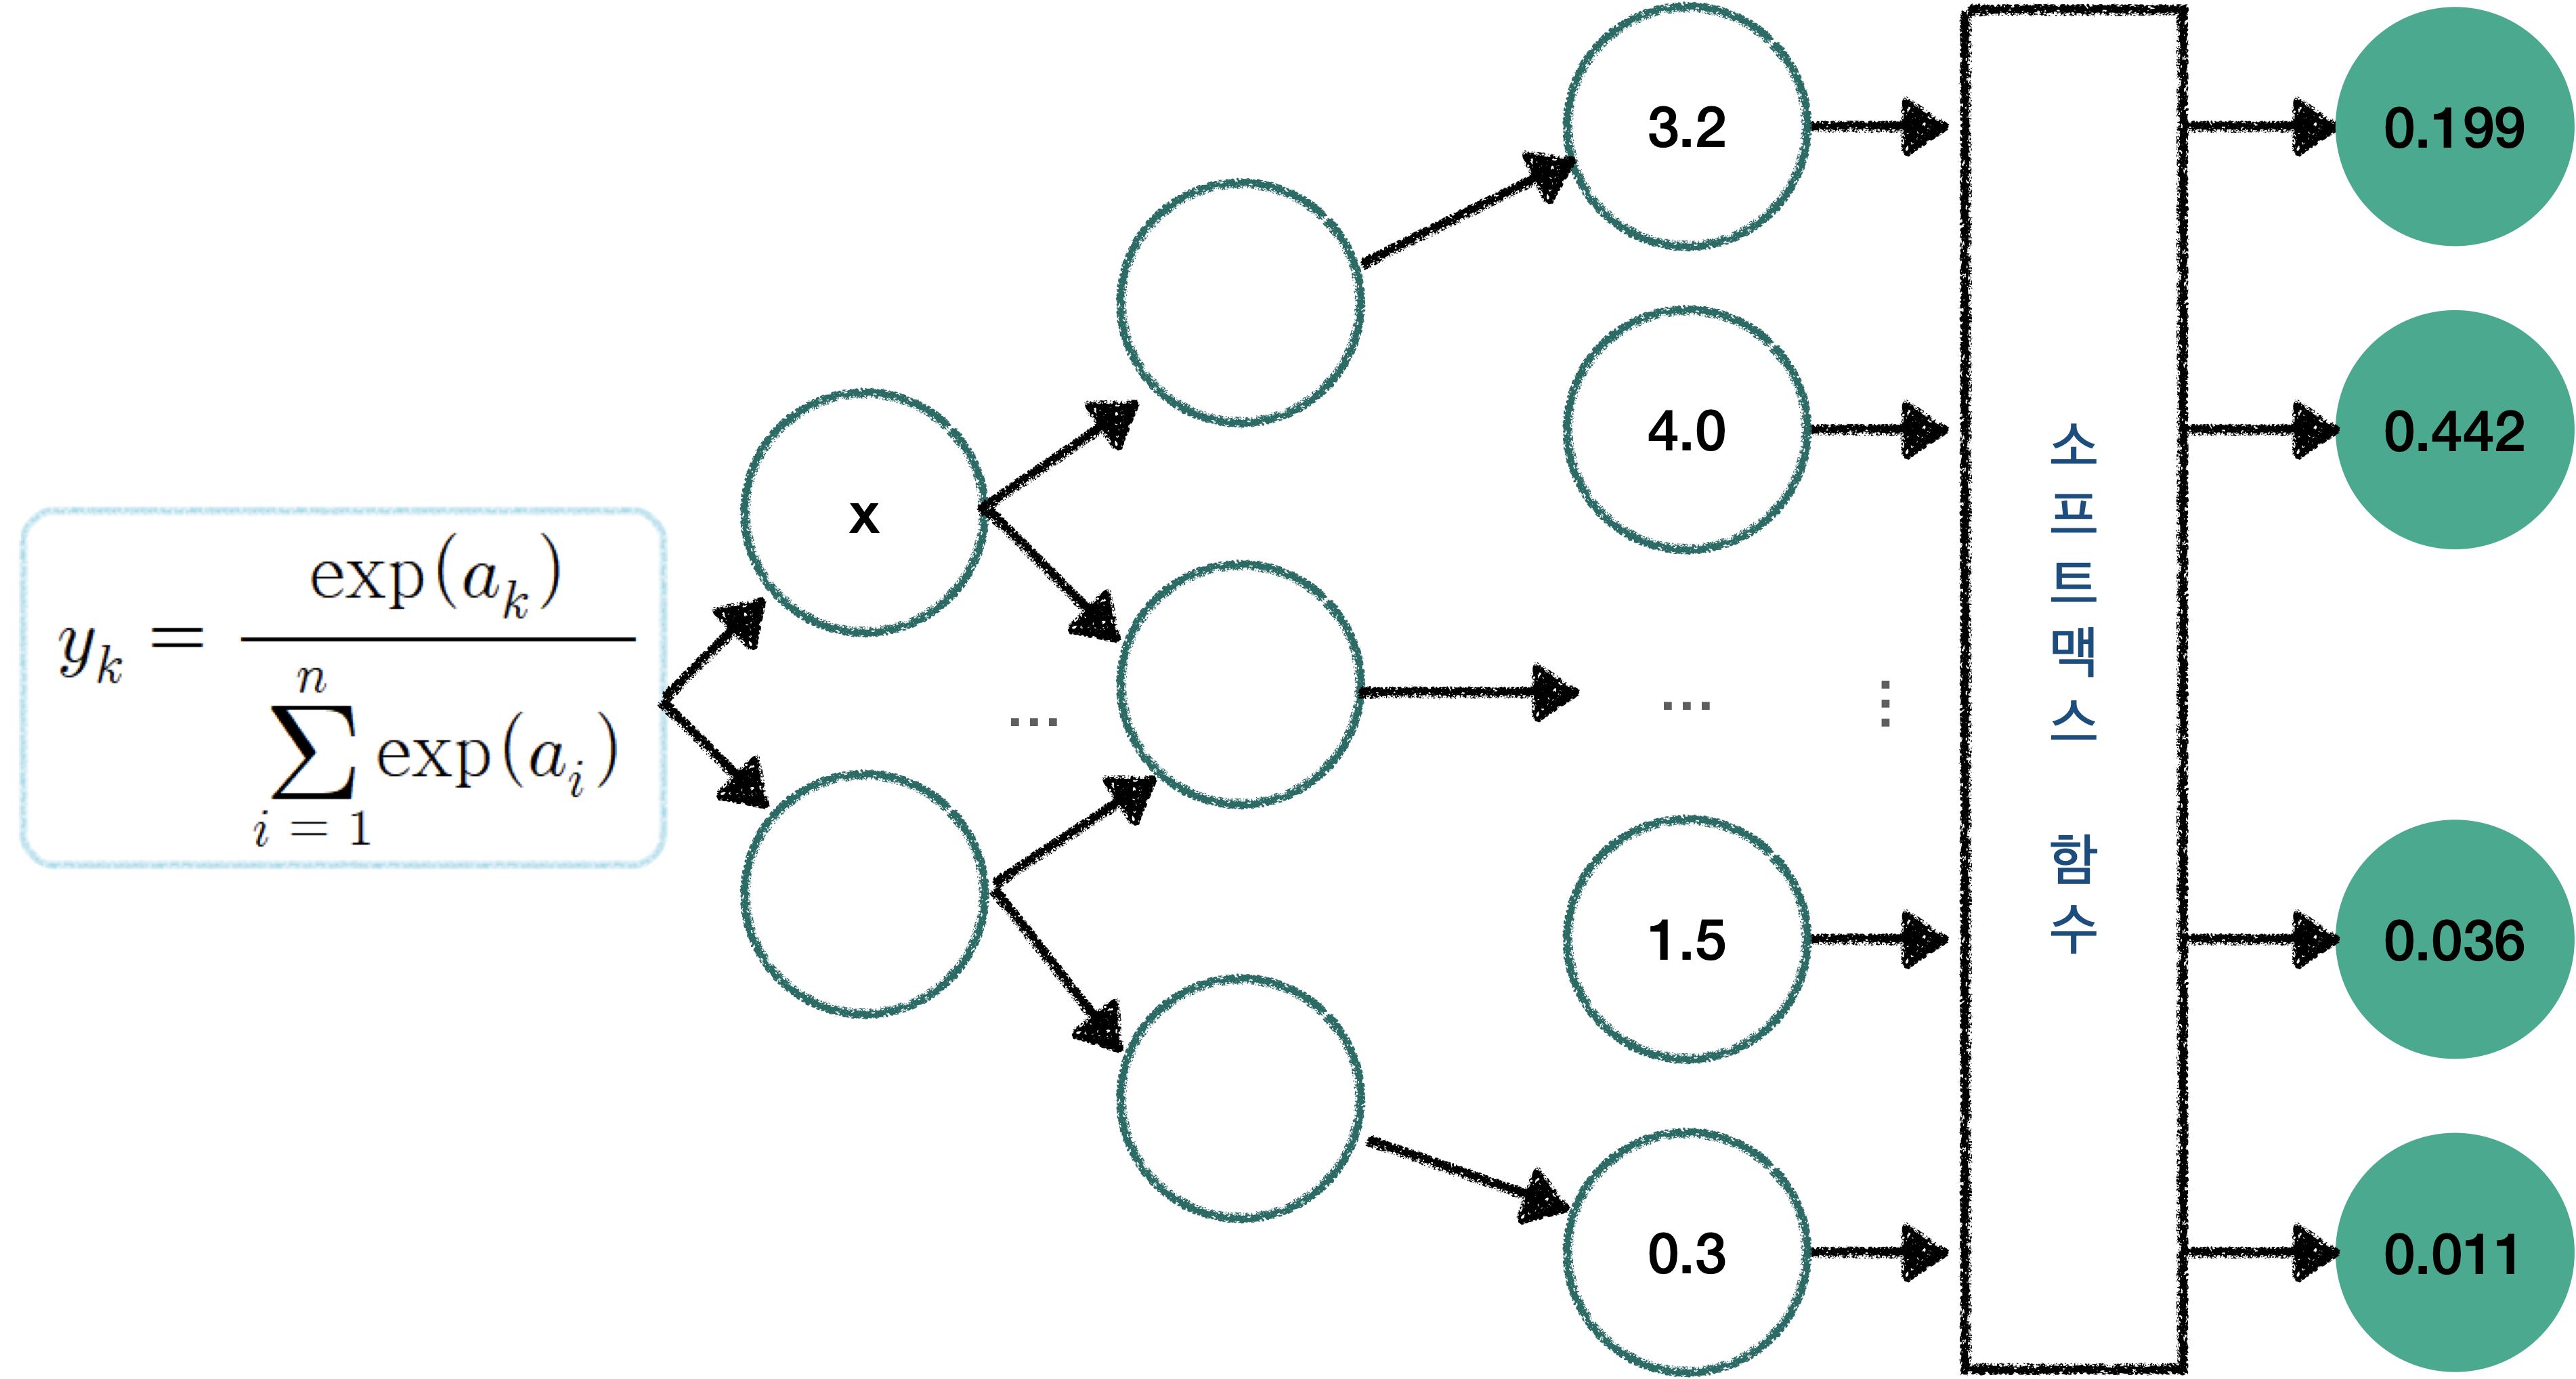

In [1]:
from IPython.display import display, Image
display(Image(filename='image22_softmax.png'))

- exp(x)는 지수함수(Exponential Function)이다. (e는 자연상수)
- n은 출력층의 뉴런 수, yk는 그 중 k번째 출력을 뜻한다

## 소프트맥스 회귀 (다항분류) 수행

### 1) 패키지 준비하기

In [2]:
import sys
sys.path.append('../../')
import helper

import numpy as np
import seaborn as sb
from pandas import read_excel, DataFrame, pivot_table
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix    # 결과보고서를 출력해주는 함수 (혼돈행렬)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical   # 더미변수 생성 함수
    # pandas의 get_dummies()는 데이터프레임만 적용 가능하지만 to_categorical()은 series도 가능

### 2) 데이터셋 준비하기
- 아이리스(붓꽃)의 꽃잎에 대한 각 부분의 너비와 길이 등을 측정한 데이터이며 `150`개의 레코드로 구성
- 꽃받침의 길이, 너비, 꽃잎의 길이, 너비 등을 토대로 `3가지로 나뉘는 붓꽃의 종류`를 분류하는 학습 모델을 구성할 수 있다

In [3]:
origin = read_excel('https://data.hossam.kr/F03/iris.xlsx')
origin.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


> 종속변수 (Species)가 이름으로 되어 있다.
>
> 분류할 때 `종속변수`는 무조건 `0으로 시작하는 일련번호`로 변환해야 된다.

### 3) 데이터 전처리
- 결측치 확인

In [4]:
origin.isna().sum()

Sepal.Length    0
Sepal.Width     0
Petal.Length    0
Petal.Width     0
Species         0
dtype: int64

- 종속변수 라벨링을 위해 값의 종류 확인
    - `.unique()`함수는 고유한 값만 출력해 줌
    - `.value_counts()`함수 활용해도 됨

In [5]:
uni = origin['Species'].unique()
print(uni)

['setosa' 'versicolor' 'virginica']


- 종속변수 라벨링
    - `cat.rename_categories({'값1': 0, '값2': 1, '값3': 2, ...})`
    - `.np.where(condition, x, y)`함수 활용해도 됨
        - condition -> 조건
        - x -> condition이 true면 x반환
        - y -> condition이 false면 y반환

In [6]:
origin['Species'] = origin['Species'].astype('category').cat.rename_categories({'setosa': 0, 'virginica': 1, 'versicolor': 2})
origin['Species'].value_counts()

Species
0    50
2    50
1    50
Name: count, dtype: int64

### 4) 탐색적 데이터 분석
- 기본통계 확인

In [7]:
origin.describe()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


> 데이터의 분포나 값들이 각 변수마다, 그리고 변수들 간에 크게 다르지 않아 표준화할 필요성은 없어보인다.

- 산점도 행렬 확인
> 여기서 산점도 행렬을 확인하는 이유는 상관관계를 확인하려는 것이 아니라 (추세선을 확인하려는 것이 아님!!! 추세선은 지금 고려하지 않아도 됨, 아무 상관 없음)
>
> `hue=종속변수`를 적용했을 때 `뚜렷한 군집을 나타내는지` 확인하기 위함
>
> 즉, `독립변수`에 따라 `종속변수`가 뚜렷히 `군집별로 나눠지는 특성`이 있는지 확인하기 위함이다

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categ

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
/Library/Frameworks/Python.framework/

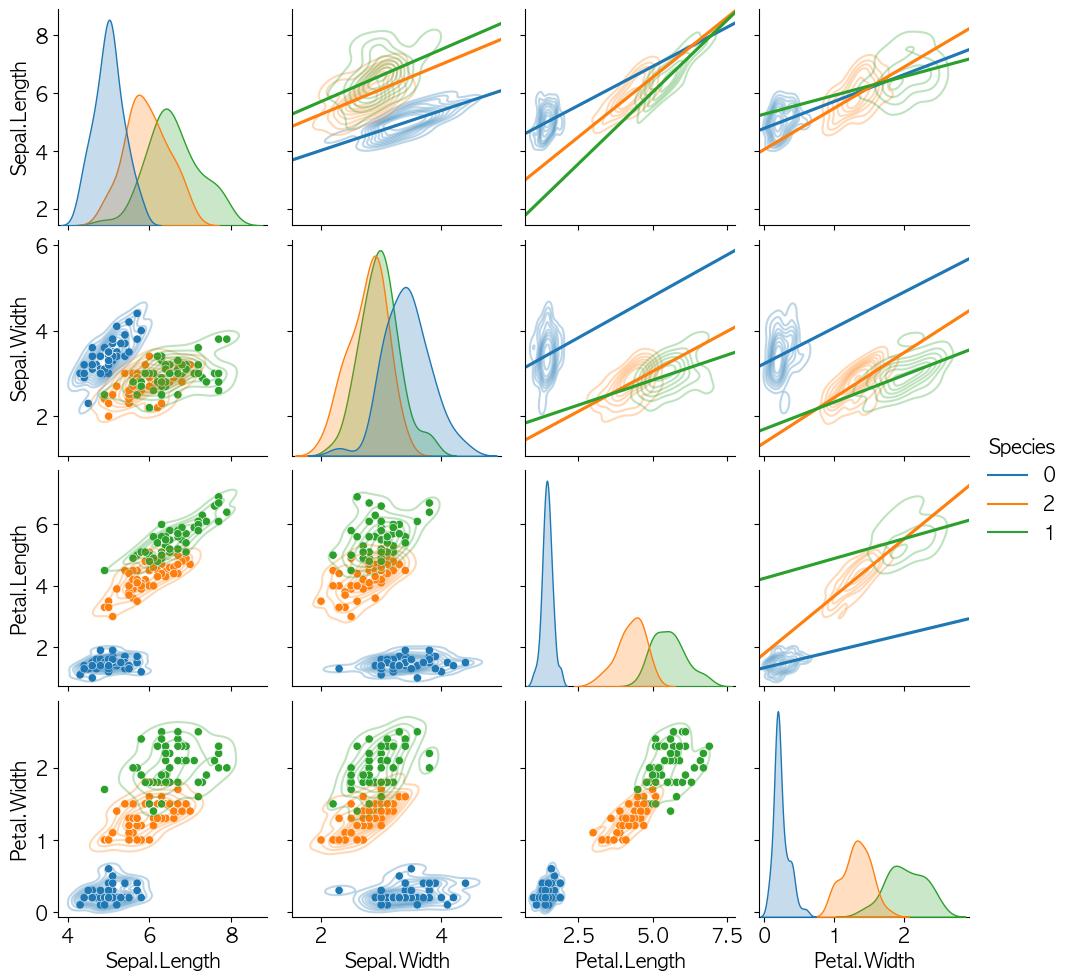

In [8]:
ax = sb.pairplot(origin, 
                 hue='Species',
                 kind='kde',
                 plot_kws={'alpha': 0.3})
ax.map_lower(sb.scatterplot)
ax.map_upper(sb.regplot, scatter=False, truncate=False, ci=False)
plt.show()
plt.close()

### 5) 데이터셋 분할
- 랜덤시드 고정

In [9]:
np.random.seed(777)

- 훈련데이터(독립변수)와 레이블(종속변수) 구분하기

In [10]:
x = origin.drop(['Species'], axis=1)
y = origin['Species']
x.shape, y.shape

((150, 4), (150,))

- 종속변수에 대한 `one-hot-encoding`
    - `to_categorical(종속변수)`
    - 통상적인 `더미변수 처리`
    - 단 계산(회귀식)을 위한 처리가 아닌 `분류를 위한 처리`이므로 `1번째 항목을 제외해서는 안 된다`.

In [11]:
y

y_categ = to_categorical(y)
y_categ

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0

- 훈련데이터와 검증데이터로 분할

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y_categ,
                                                    test_size = 0.3,
                                                    random_state=777)
print('훈련용 데이터셋 크기: %s, 훈련용 레이블셋 크기: %s' % (x_train.shape, y_train.shape))
print('검증용 데이터셋 크기: %s, 검증용 레이블셋 크리: %s' % (x_test.shape, y_test.shape))

훈련용 데이터셋 크기: (105, 4), 훈련용 레이블셋 크기: (105, 3)
검증용 데이터셋 크기: (45, 4), 검증용 레이블셋 크리: (45, 3)


### 6) 모델 개발
- 모델 정의

In [13]:
my_model = Sequential()
my_model.add(Dense(64, activation='relu', input_shape=(len(x_train.columns), )))
my_model.add(Dense(3, activation='softmax'))
my_model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['acc'])
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 515 (2.01 KB)
Trainable params: 515 (2.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


- 학습하기

In [14]:
result = my_model.fit(x_train, 
                      y_train, 
                      epochs=500, 
                      validation_data=(x_test, y_test),
                      callbacks= [EarlyStopping(monitor='val_loss',
                                                patience=5,
                                                verbose=1),
                                  ReduceLROnPlateau(monitor='val_loss',
                                                    patience=3,
                                                    factor=0.5,
                                                    min_lr=0.0001,
                                                    verbose=1)])

Epoch 1/500


4/4 [==============================] - 0s 47ms/step - loss: 1.2053 - acc: 0.3714 - val_loss: 1.1978 - val_acc: 0.2444 - lr: 0.0010
Epoch 2/500
4/4 [==============================] - 0s 7ms/step - loss: 1.1278 - acc: 0.3429 - val_loss: 1.1123 - val_acc: 0.2444 - lr: 0.0010
Epoch 3/500
4/4 [==============================] - 0s 7ms/step - loss: 1.0672 - acc: 0.3048 - val_loss: 1.0469 - val_acc: 0.2444 - lr: 0.0010
Epoch 4/500
4/4 [==============================] - 0s 7ms/step - loss: 1.0180 - acc: 0.3333 - val_loss: 0.9886 - val_acc: 0.4444 - lr: 0.0010
Epoch 5/500
4/4 [==============================] - 0s 7ms/step - loss: 0.9705 - acc: 0.4857 - val_loss: 0.9334 - val_acc: 0.5778 - lr: 0.0010
Epoch 6/500
4/4 [==============================] - 0s 7ms/step - loss: 0.9336 - acc: 0.5810 - val_loss: 0.8832 - val_acc: 0.7111 - lr: 0.0010
Epoch 7/500
4/4 [==============================] - 0s 7ms/step - loss: 0.8988 - acc: 0.6476 - val_loss: 0.8434 - val_acc: 0.7556 - lr: 0.0010
Epoch 8/500
4/4 [

### 7) 학습 결과 평가
- 기본적인 머신러닝 학습결과 평가

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning

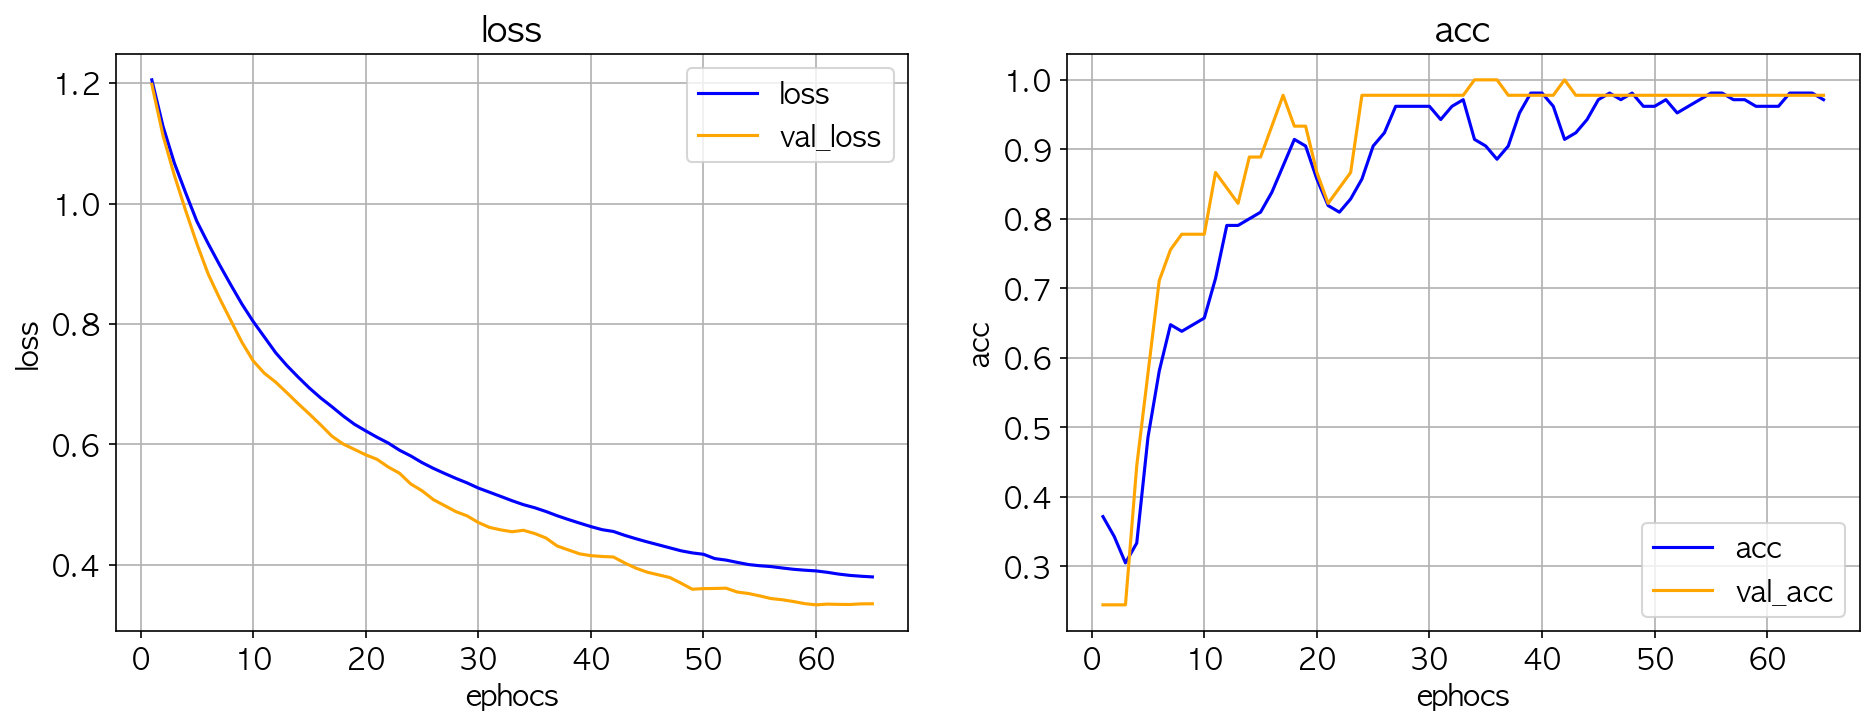

4/4 [==============================] - 0s 1ms/step - loss: 0.3796 - acc: 0.9714
최종 훈련 손실률: 0.379563, 최종 훈련 정확도: 0.971429
2/2 [==============================] - 0s 3ms/step - loss: 0.3356 - acc: 0.9778
최종 검증 손실률: 0.335565, 최종 검증 정확도: 0.977778


In [15]:
helper.tf_result_plot(result)

evaluate1 = my_model.evaluate(x_train, y_train)
print('최종 훈련 손실률: %f, 최종 훈련 정확도: %f' % (evaluate1[0], evaluate1[1]))

evaluate2 = my_model.evaluate(x_test, y_test)
print('최종 검증 손실률: %f, 최종 검증 정확도: %f' % (evaluate2[0], evaluate2[1]))

### 8) 학습 결과 적용
- 테스트 데이터에 대한 예측 결과 산정

In [16]:
results = my_model.predict(x_test)
data_count, case_count = results.shape
print('%d개의 검증 데이터가 각각 %d개의 경우의 수를 갖는다.' % (data_count, case_count))
print(results)

2/2 [==============================] - 0s 2ms/step
45개의 검증 데이터가 각각 3개의 경우의 수를 갖는다.
[[0.00520235 0.6017809  0.3930167 ]
 [0.91864705 0.01153252 0.06982045]
 [0.00538294 0.63896084 0.35565624]
 [0.00914351 0.66357136 0.32728505]
 [0.02983918 0.401908   0.56825286]
 [0.9559614  0.00482265 0.03921594]
 [0.00338367 0.66716325 0.32945308]
 [0.00609909 0.6732153  0.3206855 ]
 [0.9464722  0.00598718 0.04754049]
 [0.9419799  0.006881   0.0511391 ]
 [0.00464025 0.63415474 0.36120507]
 [0.03256301 0.3761943  0.5912427 ]
 [0.04214869 0.3855604  0.57229096]
 [0.00939774 0.567914   0.42268828]
 [0.01142623 0.60458386 0.38399   ]
 [0.01104277 0.5798132  0.40914407]
 [0.906411   0.01283026 0.08075878]
 [0.00981284 0.5687427  0.42144445]
 [0.88610256 0.01724554 0.09665195]
 [0.04270339 0.37438664 0.58291   ]
 [0.06104659 0.30166778 0.6372856 ]
 [0.02457416 0.36843473 0.6069911 ]
 [0.00229174 0.7083911  0.28931716]
 [0.91005516 0.01350607 0.0764388 ]
 [0.01172332 0.56117636 0.4271003 ]
 [0.8969871  0.01

- 가장 큰 확률 값의 인덱스들만 별도의 리스트로 생성
    - `numpy.argmax(값들, axis= -1)`
        - `가장 큰 값의 인덱스만 출력`해준다
        - axis = -1 은 축의 방향

In [17]:
arg_results = np.argmax(results, axis=-1)
arg_results

array([1, 0, 1, 1, 2, 0, 1, 1, 0, 0, 1, 2, 2, 1, 1, 1, 0, 1, 0, 2, 2, 2,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 2, 0, 0, 0, 2, 0, 0, 1, 2, 2,
       0])

- 결과 데이터셋 구성

In [18]:
result_df = DataFrame({'실제값': np.argmax(y_test, axis= -1),
                       '분류결과': arg_results})

result_df

,실제값,분류결과
0,1,1
1,0,0
2,1,1
3,1,1
4,2,2
5,0,0
6,1,1
7,1,1
8,0,0
9,0,0


#### 다항분류용 혼돈행렬 생성

- 컬럼에 따른 값의 종류 형태로 데이터 재배치

In [19]:
mdf = result_df.melt()
mdf.reset_index(inplace=True)
mdf

,index,variable,value
0,0,실제값,1
1,1,실제값,0
2,2,실제값,1
3,3,실제값,1
4,4,실제값,2
...,...,...,...
85,85,분류결과,0
86,86,분류결과,1
87,87,분류결과,2
88,88,분류결과,2


In [20]:
df = pivot_table(mdf,
                 index='value',
                 columns='variable',
                 values='index',
                 aggfunc='count')
df

variable,분류결과,실제값
value,,
0,17,17
1,18,17
2,10,11


In [21]:
cm = confusion_matrix(result_df['실제값'], result_df['분류결과'])
cmdf1 = DataFrame(cm,
                  index=[['실제값', '실제값', '실제값'],
                             [0,1,2]],
                  columns = [['분류결과', '분류결과', '분류결과'],
                             [0,1,2]])
cmdf1

분류결과        
         0   1   2
실제값 0   17   0   0
    1    0  17   0
    2    0   1  10